Parts of this notebook adapted from https://www.tensorflow.org/tutorials/generative/dcgan.

### Setup.


Import libraries.

In [ ]:
from google.colab import drive
from pathlib import Path

import sys
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import imageio
import os
import PIL
from IPython import display

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, \
                                    LeakyReLU, BatchNormalization,\
                                    Activation, UpSampling2D, \
                                    Conv2DTranspose, Dropout,\
                                    Conv2D, ReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.datasets import mnist

Define constants.

In [ ]:
NOISE_DIM = 128
IMG_ROWS = 56
IMG_COLS = 56
COLORS = True

if COLORS:
  CHANNELS = 3
else:
  CHANNELS = 1

IMG_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)
BUFFER_SIZE = 5000
BATCH_SIZE = 64
MODEL_NAME = "flowers_gan_5"


Get filenames of training set.

In [ ]:
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/')

Mounted at /content/drive


In [ ]:
sys.path.append(str(base))
zip_path = base/"EiT_dataset/flowers.zip"
!cp "{zip_path}" .
!unzip -q flowers.zip

In [ ]:
!mkdir drive/MyDrive/EiT/"{MODEL_NAME}"

In [ ]:
filenames = glob.glob("flowers/*.jpg")

Read training images into numpy arrays.

In [ ]:
if COLORS:
  train_images = np.array([cv2.resize(cv2.imread(img), (IMG_ROWS, IMG_COLS)) for img in filenames])
  train_images = train_images[:,:,:,::-1] # BRG -> RGB
else:
  train_images = np.array([cv2.resize(cv2.imread(img, 0), (IMG_ROWS, IMG_COLS)) for img in filenames])
  train_images = np.expand_dims(train_images, axis=3)

Standardize training images.

In [ ]:
train_images = (train_images - 127.5)/127.5

Create Dataset object.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Defining the models.

Defining generator architecture.

In [ ]:
def build_generator(img_shape):

    model = Sequential()

    model.add(Dense(7*7*256, input_dim=NOISE_DIM, use_bias=False))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())

    model.add(Reshape((7,7,256)))
 
    model.add(UpSampling2D())
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
    model.add(UpSampling2D())
    model.add(Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
    model.add(UpSampling2D())
    model.add(Conv2D(filters=img_shape[2], kernel_size=(5,5), strides=(1,1), padding="same", activation="tanh"))
    return model

In [ ]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(filters=128,
                     kernel_size=(5,5),
                     strides=(1,1),
                     padding="same",
                     input_shape=img_shape))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, 
                     kernel_size=(5,5),
                     strides=(2,2),
                     padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     strides=(2,2),
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(units=1,
                    activation="sigmoid"))
    return model

Create instances of each model.


In [ ]:
generator = build_generator(IMG_SHAPE)
discriminator = build_discriminator(IMG_SHAPE)

Defining loss functions and optimizers.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Defining training.

In [ ]:
EPOCHS = 50

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  batches_per_epoch = len(dataset)

  generator_losses = np.empty(shape=batches_per_epoch*epochs) # Length: total number of batches.
  discriminator_losses = np.empty(shape=batches_per_epoch*epochs)

  for epoch in range(epochs):
    start = time.time()
    
    batch_counter = 0

    for image_batch in dataset:

      gen_loss, disc_loss = train_step(image_batch)

      generator_losses[epoch*batches_per_epoch + batch_counter] = gen_loss
      discriminator_losses[epoch*batches_per_epoch + batch_counter] = disc_loss
      
      batch_counter += 1


    print ('Epoch {} took {} seconds.'.format(epoch + 1, time.time()-start))

  return generator_losses, discriminator_losses

### Train the models.


In [1]:
generator_losses, discriminator_losses = train(train_dataset, EPOCHS)

NameError: ignored

Plot losses for each batch.

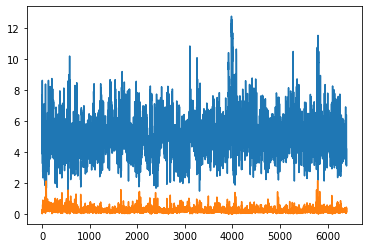

In [ ]:
plt.plot(generator_losses)
plt.plot(discriminator_losses)

Show a generated test image.

In [ ]:
test_noise = tf.random.normal(0, 1, [1, NOISE_DIM])
img = generator.predict(test_noise)
plt.imshow(tf.cast(img[0, :, :, :] * 127.5 + 127.5, tf.int32))